<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Figure-28.1" data-toc-modified-id="Figure-28.1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 28.1</a></span></li><li><span><a href="#Figure-28.2" data-toc-modified-id="Figure-28.2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 28.2</a></span></li><li><span><a href="#Figure-28.3" data-toc-modified-id="Figure-28.3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Figure 28.3</a></span></li><li><span><a href="#Figure-28.4" data-toc-modified-id="Figure-28.4-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure 28.4</a></span></li><li><span><a href="#Figure-28.5" data-toc-modified-id="Figure-28.5-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Figure 28.5</a></span></li><li><span><a href="#Figure-28.6" data-toc-modified-id="Figure-28.6-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Figure 28.6</a></span></li><li><span><a href="#Figure-28.7" data-toc-modified-id="Figure-28.7-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Figure 28.7</a></span></li><li><span><a href="#Figure-28.9" data-toc-modified-id="Figure-28.9-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Figure 28.9</a></span></li></ul></div>

In [1]:
## Analyzing Neural Time Series Data
# Python code for Chapter 28
# Yujin Goto (MATLAB original code: Mike X Cohen)
# 
# This code accompanies the book, titled "Analyzing Neural Time Series Data" 
# (MIT Press). Using the code without following the book may lead to confusion, 
# incorrect data analyses, and misinterpretations of results. 
# Mike X Cohen and Yujin Goto assumes no responsibility for inappropriate or incorrect use of this code. 

In [21]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats
from scipy import signal
from scipy.stats import zscore

import mne
from mne import events_from_annotations

In [2]:
# load EEG data (.vhdr converted ver. by Yujin)
mne.set_log_level('CRITICAL') # delete this line for your environment
raw = mne.io.read_raw_brainvision('./NeuralData/sampleEEGdata_convert.vhdr', eog=['HEOG', 'VEOG'], preload=True)
mne.set_log_level('INFO') # delete this line for your environment

# load electrodes location montage
montage = mne.channels.read_custom_montage('./NeuralData/sampleEEG_loc.loc')
raw.set_montage(montage)

# Getting event timings (for .mat file, you don't have to do this.) and epoching
events, event_dict = events_from_annotations(raw)

epochs = mne.Epochs(
    raw,
    events,
    event_id = {'New Segment/': 99999},
    tmin = 0,
    tmax = 2.496,
    baseline = None,
)

# Extract variables
data = epochs.get_data()*(10**6)                 # EEG data (array; trial, ch, time). MNE-pyton reads data in volts(V), not microvolts (μV).
pnts = data.shape[2]                             # Number of points in EEG data (scalar)
times = epochs.times-1                           # Time points of data (array)
tmin = epochs.tmin-1                             # The start timing of epoch (the start timing of the baseline is set to be 0 in default)
tmax = epochs.tmax-1                             # The end timing of epoch
srate = epochs.info['sfreq']                     # Sampling rate (scalar)
trials = len(epochs.events)                      # Trials (scalar)
nbchan = len(epochs.ch_names)                    # Number of channel (scalar)


chan_labels = epochs.info['ch_names']

# channel locations
chan_pos2D = []
chan_pos3D = []
for ch in epochs.info['chs']:
    x,y,z = ch['loc'][:3]
    chan_pos2D.append((x,y))
    chan_pos3D.append((x,y,z))
    
#chan2useidx = chan_labels.index('Pz')

Used Annotations descriptions: ['New Segment/', 'Stimulus/1', 'Stimulus/2', 'Stimulus/31', 'Stimulus/32', 'Stimulus/51', 'Stimulus/52']
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 99 events and 640 original time points ...
0 bad epochs dropped


## Figure 28.1

Text(0.5, 1.0, 'Non-stationary autoregressive process')

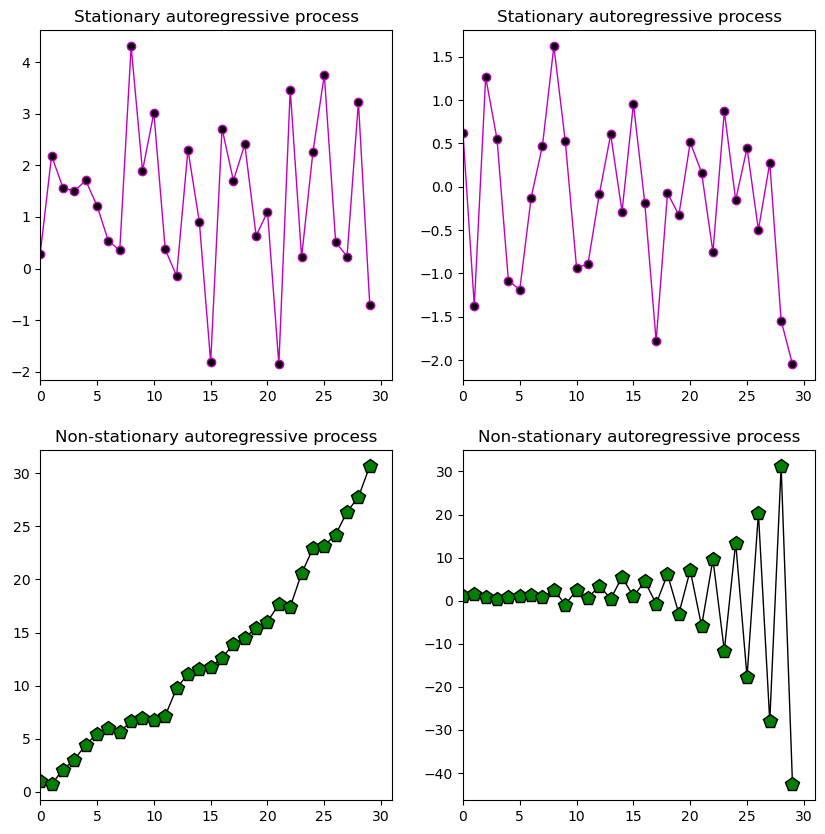

In [6]:
# - Stationary-like process - #

plt.figure(figsize=(10,10))

x = [np.random.randn()]
for i in range(1, 30):
    x.append(np.exp(np.cos(np.pi * x[i - 1])) + np.random.randn())

plt.subplot(221)
plt.plot(x, 'mo-', linewidth=1, markerfacecolor='k', markersize=6)
plt.xlim([0, 31])
plt.title('Stationary autoregressive process')


x = np.random.randn(2)
for i in range(2, 30):
    x = np.append(x, 0.2 * x[i - 1] - 0.4 * x[i - 2] + np.random.randn())

plt.subplot(222)
plt.plot(x, 'mo-', linewidth=1, markerfacecolor='k', markersize=6)
plt.xlim([0, 31])
plt.title('Stationary autoregressive process')




# - Non-stationary process - #

x = [1]
for i in range(1, 30):
    x.append(1.1 * x[i - 1] + np.random.randn())

plt.subplot(223)
plt.plot(x, 'kp-', linewidth=1, markerfacecolor='g', markersize=10)
plt.xlim([0, 31])
plt.title('Non-stationary autoregressive process')


x = [1, 1.5]
for i in range(2, 30):
    x.append(1.2 * x[i - 2] - 0.3 * x[i - 1] + np.random.randn())

plt.subplot(224)
plt.plot(x, 'kp-', linewidth=1, markerfacecolor='g', markersize=10)
plt.xlim([0, 31])
plt.title('Non-stationary autoregressive process')

## Figure 28.2

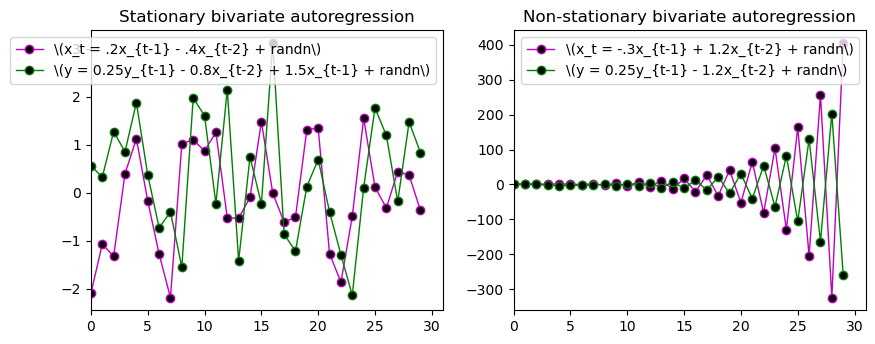

In [9]:
plt.figure(figsize=(10,8))
# - Stationary-like process - #

# define X
x = np.random.randn(2)
for i in range(2, 30):
    x = np.append(x, 0.2 * x[i - 1] - 0.4 * x[i - 2] + np.random.randn())


# define y
y = np.random.rand(2)
for i in range(2, 30):
    y = np.append(y, 0.25 * y[i - 1] - 0.8 * x[i - 2] + 1.5 * x[i - 1] + np.random.randn())

plt.subplot(221)
plt.plot(x, 'mo-', linewidth=1, markerfacecolor='k', markersize=6)
plt.plot(y, 'go-', linewidth=1, markerfacecolor='k', markersize=6)
plt.xlim([0, 31])
plt.title('Stationary bivariate autoregression')
plt.legend(['\(x_t = .2x_{t-1} - .4x_{t-2} + randn\)', '\(y = 0.25y_{t-1} - 0.8x_{t-2} + 1.5x_{t-1} + randn\)'])




# - Non-stationary process - #

# Define x
x = np.array([1, 1.5])
for i in range(2, 30):
    x = np.append(x, 1.2 * x[i - 2] - 0.3 * x[i - 1] + np.random.randn())

# Define y
y = np.random.rand(2)
for i in range(2, 30):
    y = np.append(y, 0.25 * y[i - 1] - 1.2 * x[i - 2] + np.random.randn())


plt.subplot(222)
plt.plot(x, 'mo-', linewidth=1, markerfacecolor='k', markersize=6)
plt.plot(y, 'go-', linewidth=1, markerfacecolor='k', markersize=6)
plt.xlim([0, 31])
plt.title('Non-stationary bivariate autoregression')
plt.legend(['\(x_t = -.3x_{t-1} + 1.2x_{t-2} + randn\)', '\(y = 0.25y_{t-1} - 1.2x_{t-2} + randn\)'])

## Figure 28.3

In [57]:
'''# Define a function for autoregressive modeling (as a simple version of armorf)
from numpy.linalg import inv
def armorf(data, order):
    """
    Autoregressive modeling using Yule-Walker equations.
    """
    R = np.correlate(data, data, mode='full')[len(data)-1:]
    R /= len(data)  # normalization
    Rmat = np.array([R[abs(k):order+abs(k)] for k in range(order)])
    R0 = R[:order]
    AR_coeffs = inv(Rmat).dot(R0)
    prediction_error = R[0] - AR_coeffs.dot(R0)
    return AR_coeffs, prediction_error'''

In [123]:
# define channels for granger prediction
chan1name = 'O1'
chan2name = 'F5'

# Granger prediction parameters
timewin = 200 # in ms
order   =  27 # in ms

# temporal down-sample results (but not data!)
times2save = np.arange(-.4, 1.001, .02) # in s


# convert parameters to indices
timewin_points = round(timewin / (1000 / srate))
order_points = round(order / (1000 / srate))


# find the index of those channels
chan1 = chan_labels.index(chan1name)
chan2 = chan_labels.index(chan2name)

# Remove ERP from selected electrodes to improve stationarity (adjust according to your EEG object)
eegdata = data[:, [chan1, chan2], :] - np.mean(data[:, [chan1, chan2], :], axis=0)
#eegdata = eegdata.transpose((1,2,0))
# convert requested times to indices (adjust according to your EEG object)
times2saveidx = np.array([np.argmin(np.abs(times - t)) for t in times2save])

# Initialize
x2y, y2x = np.zeros(len(times2save)), np.zeros(len(times2save))

#bic = zeros(length(times2save),15); % Bayes info criteria (hard-coded to order=15)

for timei, timeidx in enumerate(times2saveidx):
    # Data from all trials in this time window
    tempdata = eegdata[:, :, timeidx - timewin_points//2-1:timeidx + timewin_points//2]
    

    for triali in range(tempdata.shape[0]):
    # Detrend and Z-score channel 1
        tempdata[triali, 0, :] = zscore(signal.detrend(tempdata[triali, 0, :]))
        tempdata[triali, 1, :] = zscore(signal.detrend(tempdata[triali, 1, :]))

    # reshape tempdata for armorf
    #tempdata = np.reshape(tempdata,[2,timewin_points*trials])
    
    # AR model fitting for channel 1, channel 2, and both
    AR_x, Ex = armorf(tempdata[0, :], trials, timewin_points, order_points)
    AR_y, Ey = armorf(tempdata[1, :], trials, timewin_points, order_points)
    AR_xy, E = armorf(tempdata.flatten(), trials, timewin_points,  order_points)

    # Granger prediction calculation
    y2x[timei] = np.log(Ex / E)
    x2y[timei] = np.log(Ey / E)

# Draw lines
plt.figure()
plt.plot(times2save, x2y, label=f'GP: {chan1name} -> {chan2name}')
plt.plot(times2save, y2x, 'r', label=f'GP: {chan2name} -> {chan1name}')
plt.legend()
plt.title(f'Window length: {timewin} ms, order: {order} ms')
plt.xlabel('Time (ms)')
plt.ylabel('Granger prediction estimate')
plt.show()

ValueError: operands could not be broadcast together with shapes (2,49) (2,0) 

## Figure 28.4

## Figure 28.5

In [139]:
min_freq = 10 # in Hz, using minimum of 10 Hz because of 200-ms window
max_freq = 40

order_points = 15

frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq), 15)

# initialize
tf_granger = np.zeros((2,len(frequencies),len(times2save)))

## Figure 28.6

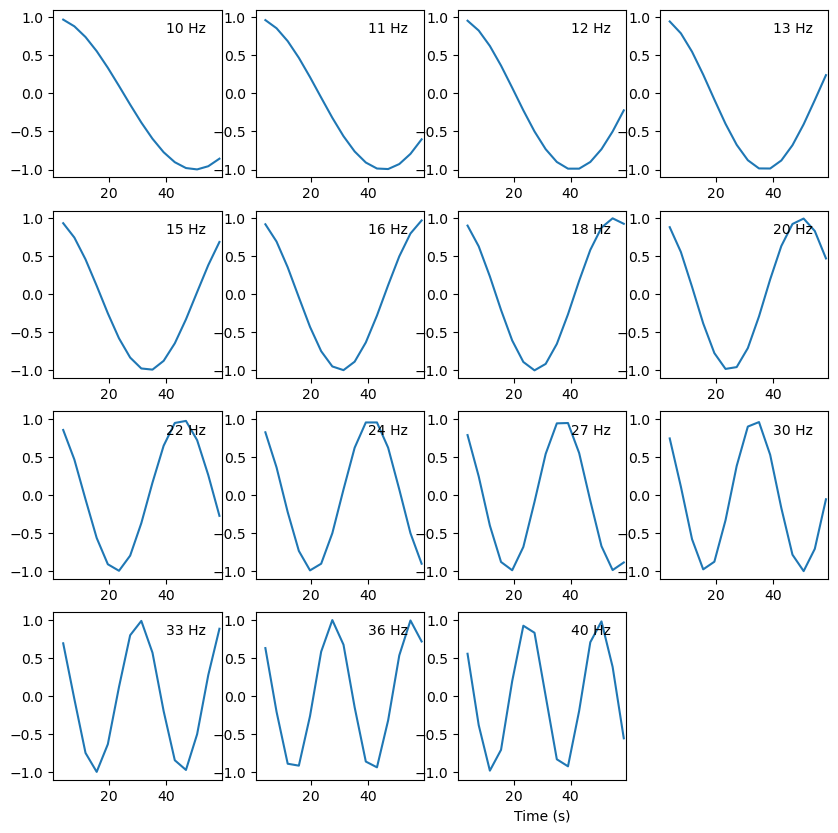

In [145]:
plt.figure(figsize=(10,10))

for fi, freq in enumerate(frequencies, start=1):
    plt.subplot(4, 4, fi)
    times = (np.arange(1, order_points + 1) * (1000 / srate))
    sine_wave = np.real(np.exp(-1j * (np.arange(1, order_points + 1)) * 2 * np.pi * freq / srate))
    
    plt.plot(times, sine_wave)
    plt.xlim([0.5, 1.015 * order_points * (1000 / srate)])
    plt.ylim([-1.1, 1.1])
    plt.text(40, 0.8,f"{round(freq)} Hz")

_=plt.xlabel('Time (s)')

## Figure 28.7

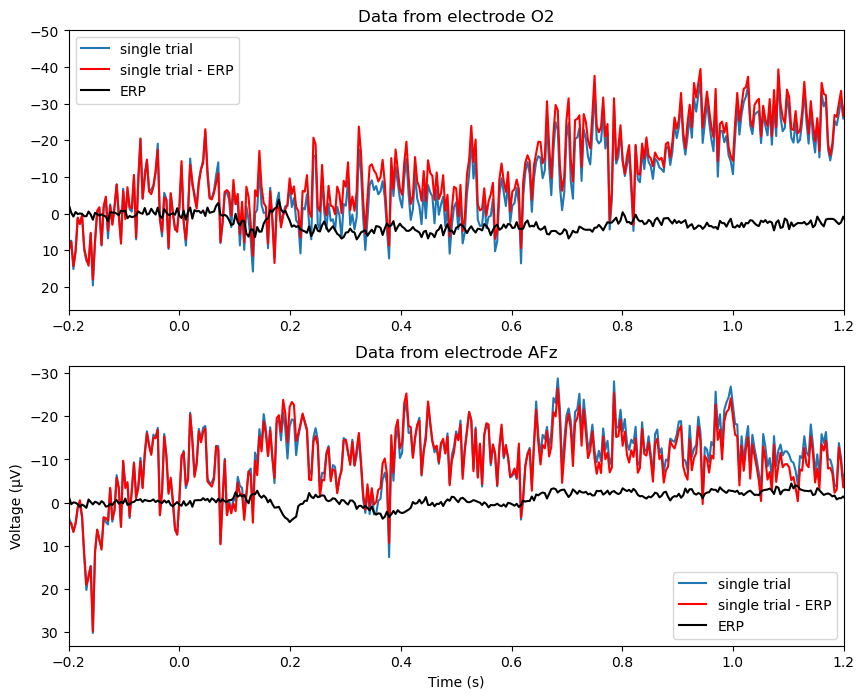

In [137]:
# Find index of the electrode 'O2'
electrode2plot = chan_labels.index('O2')
erp = np.mean(data[:, electrode2plot, :], axis=0)  # Calculate ERP

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(times, data[0, electrode2plot, :], label='single trial')
plt.plot(times, data[0, electrode2plot, :] - erp, 'r', label='single trial - ERP')
plt.plot(times, erp, 'k', label='ERP')
plt.xlim([-.2, 1.2])
plt.gca().invert_yaxis()  # Invert y-axis
plt.legend()
plt.title("Data from electrode O2")

# Repeat for electrode 'AFz'
electrode2plot = chan_labels.index('AFz')
erp = np.mean(data[:, electrode2plot, :], axis=0)  # Calculate ERP

plt.subplot(212)
plt.plot(times, data[0, electrode2plot, :], label='single trial')
plt.plot(times, data[0, electrode2plot, :] - erp, 'r', label='single trial - ERP')
plt.plot(times, erp, 'k', label='ERP')
plt.setp(plt.gca(), 'xlim', [-.2, 1.2], 'xlabel', 'Time (s)', 'ylabel', 'Voltage (μV)')
plt.gca().invert_yaxis()  # Invert y-axis
plt.legend()
_=plt.title("Data from electrode AFz")

## Figure 28.8

## Figure 28.9

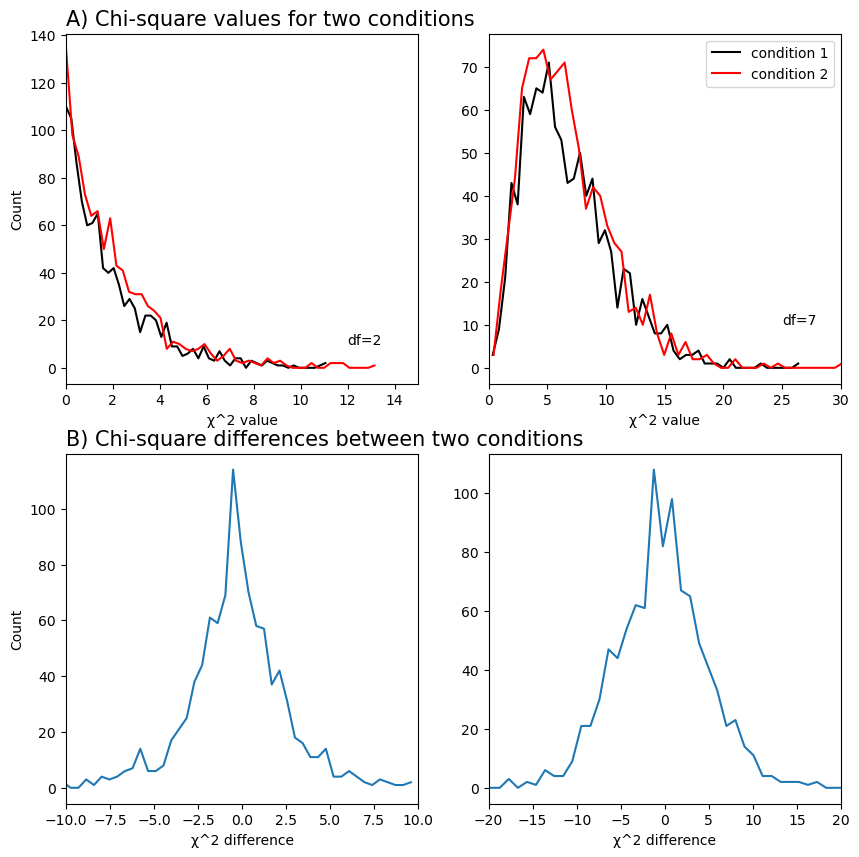

In [146]:
# generate two chi-square distributed random numbers
d1 = np.random.chisquare(2, 1000)
d2 = np.random.chisquare(2, 1000)

# Get histograms
y1, x1 = np.histogram(d1, bins=50)
y2, x2 = np.histogram(d2, bins=50)
y3, x3 = np.histogram(d1-d2, bins=50)

plt.figure(figsize=(10,10))

plt.subplot(221)
plt.plot(x1[:-1], y1, 'k')
plt.plot(x2[:-1], y2, 'r')
plt.setp(plt.gca(), 'xlim', [0, 15], 'xlabel', 'χ^2 value', 'ylabel', 'Count')
plt.text(12,10,'df=2')
plt.title('A) Chi-square values for two conditions', loc='left', fontsize=15)

plt.subplot(223)
plt.plot(x3[:-1], y3)
plt.setp(plt.gca(), 'xlim', [-10, 10], 'xlabel', 'χ^2 difference', 'ylabel', 'Count')
plt.title('B) Chi-square differences between two conditions', loc='left', fontsize=15)

# once more, with new distributions
d1 = np.random.chisquare(7, 1000)
d2 = np.random.chisquare(7, 1000)

# Get histograms
y1, x1 = np.histogram(d1, bins=50)
y2, x2 = np.histogram(d2, bins=50)
y3, x3 = np.histogram(d1-d2, bins=50)

plt.subplot(222)
plt.plot(x1[:-1], y1, 'k', label='condition 1')
plt.plot(x2[:-1], y2, 'r', label='condition 2')
plt.text(25,10,'df=7')
plt.legend()
plt.setp(plt.gca(), 'xlim', [0, 30], 'xlabel', 'χ^2 value')

plt.subplot(224)
plt.plot(x3[:-1], y3)
_=plt.setp(plt.gca(), 'xlim', [-20, 20], 'xlabel', 'χ^2 difference')